# 신용카드 사기 검출 

일반적인 사기 검출(Fraud Detection)이나 이상 검출(Anomaly Detection)과 같은 데이터 세트는 레이블 값이 극도로 불균형한 분포를 가지기 쉬움.   
그 이유는 사기와 같은 이상 현상은 전체 데이터에서 차지하는 비중이 매우 적을 수 밖에 없음 

### 불균형한 레이블의 데이터 세트
레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능 문제 발생 가능성이 존재.  
-> 이는 이상 레이블을 가지는 데이터 건수가 정상 레이블 가진 데이터 건수에 비해 너무 적기 떄문에 발생함.   

이상 레이블을 가지는 데이터 건수는 매우 적기 때문에 제대로 다양한 유형을 학습을 못함.  
반면, 정상 레이블을 가지느 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블에 치우는 학습을 수행해 제대로 된 이상 데이터 검출이 어려워지기 쉬움.  

이러한 불균형한 레이블 분포로 인한 문제를 해결하기 위해서 적절한 학습 데이터를 확보하는 방안이 필요.  
-> Over Sampling / Under Sampling 

    * Over Sampling : 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법.  
                    단순히 증식하는 방법은 과적합이 되기 때문에 원본 데이터 피처 값들을 아주 약간만 변경하여 증식.  
                    ex) SMOTE(Synthetic Minority Over-Sampling Technique)   
                        : 적은 데이터 세트에 있는 개별 데이터들의 K Nearest Neighbor을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서   
                        기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성해 내는 방식. 
                        - from imblearn.over_sampling import SMOTE
                        
    
    * Under Sampling : 많은 데이터 세틑를 적은 데이터 세트 수준으로 감소시키는 방법.  
                    정상 레이블 데이터를 이상 레이블 데이터 수준으로 줄여버리는 방식으로 이 상태에서 학습을 수행할 경우, 정상 레이블 위주의 학습/예측의 부작용을 개선할 수 있지만,  
                    너무 많은 정상 레이블 데이터를 감소함에 따라 제대로 된 학습을 수행할 수 없다는 단점이 있어 잘 적용하지 않는 방법. 


In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from mlGuideFunc import get_clf_eval 
from sklearn.model_selection import train_test_split 

pd.set_option('display.max_columns', None)

card_df = pd.read_csv('data/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
card_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [4]:
print('이상 레이블의 비율 : {:2%}'.format(card_df[card_df['Class'] == 1].Class.count()/card_df['Class'].count()) )

이상 레이블의 비율 : 0.172749%


전체 데이터 세트 중 이상 레이블의 비중은 0.17% 밖에 차지하지 않음.

In [20]:
from sklearn.linear_model import LogisticRegression 
from lightgbm import LGBMClassifier

### #1.데이터 일차 가공 및 모델 학습/예측/평가

In [9]:
# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환 

def get_preprocessed_df(df = None):
    df_copy = df.copy()
    df_copy.drop('Time', axis =1, inplace =True)
    
    return df_copy

In [11]:
#사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수 

def get_train_test_dataset(df= None):
    # 1. 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환 
    df_copy = get_preprocessed_df(df)
    
    # 2. DataFrame의 맨 마지막 칼럼이 레이블, 나머지 features 
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    
    # 3. train_test_split()로 데이터 분할 
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3,
                                                       random_state = 0, stratify = y_target ) # stratify : 학습과 테스트 데이터 세트의 레이블 분포도 동일하게 지정  
    
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [10]:
print('학습 데이터 레이블 값 비율 ')
print(y_train.value_counts()/y_train.shape[0] * 100)

print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100 )

학습 데이터 레이블 값 비율 
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


#### 로지스틱 회귀 모델 

In [11]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

In [13]:
get_clf_eval(y_test, lr_pred)

오차행렬
[[85279    16]
 [   59    89]]
정확도 : 0.9991 , 정밀도 : 0.8476, 재현율 : 0.6014, F1 : 0.7036, auc : 0.8006


#### LigthGBM 

In [17]:
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    get_clf_eval(tgt_test, pred)

In [16]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs =1, boost_from_average = False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

오차행렬
[[85290     5]
 [   36   112]]
정확도 : 0.9995 , 정밀도 : 0.9573, 재현율 : 0.7568, F1 : 0.8453, auc : 0.8783


### #2.데이터 분포도 변환 후 모델 학습/예측/평가 

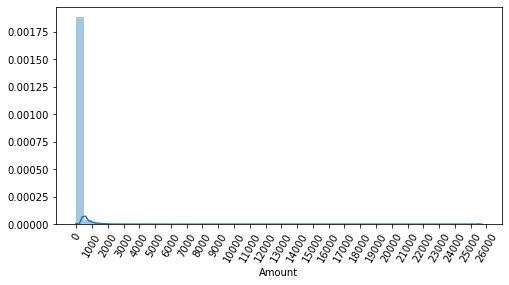

In [5]:
plt.figure(figsize = (8,4))
plt.xticks(range(0, 30000,1000), rotation = 60)

sns.distplot(card_df['Amount'])

카드 사용 금액이 1000불 이하가 대부분이며, 26000불까지 사용한 경우 발생하면서 꼬리가 긴 형태의 분포 곡선을 가지고 있음.  
Amount을 표준 정규분포 형태로 변환 

In [32]:
from sklearn.preprocessing import StandardScaler

def get_perprocessed_df(df = None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].value.reshape(-1,1))
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

In [33]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [34]:
print('## 로지스틱 회귀 예측 성능 ##')


lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train, X_test, y_train,y_test )

## 로지스틱 회귀 예측 성능 ##
오차행렬
[[85279    16]
 [   59    89]]
정확도 : 0.9991 , 정밀도 : 0.8476, 재현율 : 0.6014, F1 : 0.7036, auc : 0.8006


In [35]:
print('## LightGBM 예측 성능 ##')

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = 1, boost_from_average = False)
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

## LightGBM 예측 성능 ##
오차행렬
[[85290     5]
 [   36   112]]
정확도 : 0.9995 , 정밀도 : 0.9573, 재현율 : 0.7568, F1 : 0.8453, auc : 0.8783


표준 정규분포를 적용하였을 때 재현율의 변화가 크지 않았음. -> 로그변환   
로그변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중 하나.  
원래 값을 log 값으로 변환해 원래 값을 상대적으로 작은 값으로 변환하기 때문에 분포도의 왜곡 현상 개선 가능.  

In [36]:
def get_proprocessed_df(df = None):
    df_copy = df.copy()
    
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    df_copy.drop(['Time','Amount'], axis =1, inplace =True)
    
    return df_copy

In [37]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [39]:
print("## 로지스틱 회귀 예측 성능 ")
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print("## LightGBM 예측 성능 ")
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

## 로지스틱 회귀 예측 성능 
오차행렬
[[85279    16]
 [   59    89]]
정확도 : 0.9991 , 정밀도 : 0.8476, 재현율 : 0.6014, F1 : 0.7036, auc : 0.8006
## LightGBM 예측 성능 
오차행렬
[[85290     5]
 [   36   112]]
정확도 : 0.9995 , 정밀도 : 0.9573, 재현율 : 0.7568, F1 : 0.8453, auc : 0.8783


### #3. 이상치 데이터 제거 후 모델 학습/예측/평가

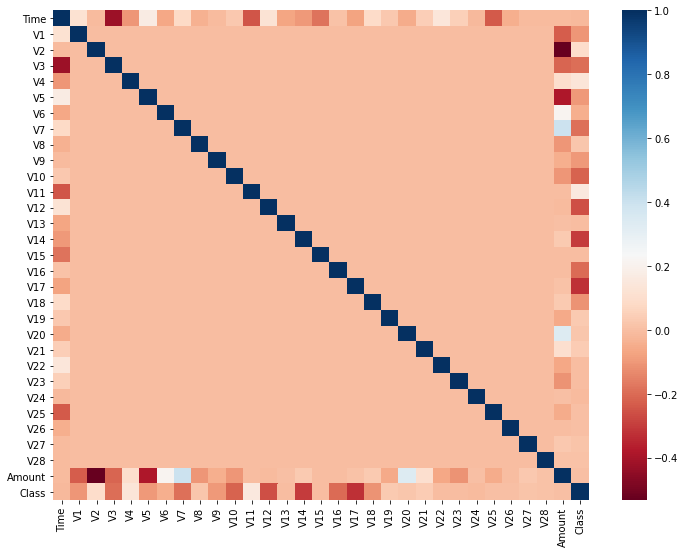

In [43]:
plt.figure(figsize = (12, 9))
corr = card_df.corr()

sns.heatmap(corr, cmap ='RdBu')

Feature가 많을 걍우 이들 중 결정값과 가장 상관성이 높은 피러들을 위주로 이상치를 검출하는 것이 좋음.  
결정값과 상관성이 높지 않은 경우의 피처의 이상치를 제거하더라도 크게 성능 향상에 기여하지 않음.  

In [51]:
#  데이터 프레임에서 이상치 검출 칼럼을 입력받아 IQR 기반에 해당 이상치의 index 반환 

def get_outlier(df = None, column = None, weight = 1.5 ):
    
    # Fraud 즉 사기에 해당하는 column 데이터만 추출
    fraud = df[df['Class'] == 1][column]
    
    # 1/4 지점과 3/4 지정을 np.percentile 로 구함 
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    # IQR : Q1- Q3
    iqr = quantile_75 - quantile_25
    
    iqr_weight = iqr*weight 
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최댓값보다 크거나 최솟값보다 작은 값을 이상치 데이터로 설정 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [52]:
outlier_index = get_outlier(card_df, column ='V14') # 레이블과 상관성이 높았던 V14 의 이상치 확인
print('이상치 데이터 인덱스: ', outlier_index)

이상치 데이터 인덱스:  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [55]:
# get_preprocessed_df : 로그변화 -> 이상치 제거 

def get_preprocessed_df(df = None):
    df_copy = df.copy()
    
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    df_copy.drop(['Time', 'Amount'], axis =1, inplace =True)
    
    outlier_index = get_outlier(df_copy, 'V14')
    df_copy.drop(outlier_index, axis =0, inplace = True)
    
    return df_copy

In [56]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [57]:
print("## 로지스틱 회귀 예측 성능 ")
get_model_train_eval(lr_clf, X_train, X_test, y_train, y_test)

print('## LightGBM 예측 성능')
get_model_train_eval(lgbm_clf, X_train, X_test, y_train, y_test)

## 로지스틱 회귀 예측 성능 
오차행렬
[[85281    14]
 [   48    98]]
정확도 : 0.9993 , 정밀도 : 0.8750, 재현율 : 0.6712, F1 : 0.7597, auc : 0.8355
## LightGBM 예측 성능
오차행렬
[[85290     5]
 [   25   121]]
정확도 : 0.9996 , 정밀도 : 0.9603, 재현율 : 0.8288, F1 : 0.8897, auc : 0.9144


이상치를 제거하여 예측 성능을 확인한 경우 재현율이 소폭 올라감. 

### #4. SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가 

In [61]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)

print('SMOTE 적용 전 학습용 데이터 세트 : ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 데이터 세트 : ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 데이터 세트 :  (199362, 29) (199362,)
SMOTE 적용 후 학습용 데이터 세트 :  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포:
 1    199020
0    199020
Name: Class, dtype: int64


In [63]:
get_model_train_eval(lr_clf, X_train_over, X_test, y_train_over, y_test)

오차행렬
[[82937  2358]
 [   11   135]]
정확도 : 0.9723 , 정밀도 : 0.0542, 재현율 : 0.9247, F1 : 0.1023, auc : 0.9485


재현율은 92.5% 로 매우 높게 나온 반면 정밀도는 5% 로 급격하게 저하.  
재현율인 높지만 이 정도로 저조한 정밀도로는 현실 업무에 적용할 수 없음. 

In [65]:
from mlGuideFunc import precision_recall_curve_plot

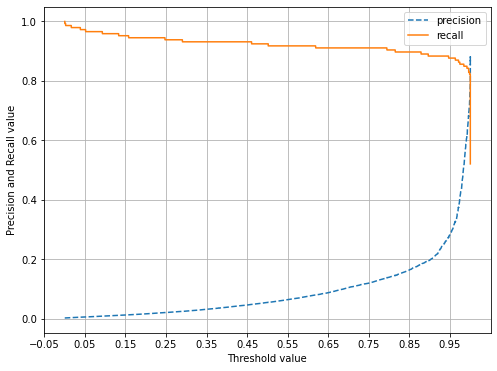

In [66]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [67]:
get_model_train_eval(lgbm_clf, X_train_over, X_test, y_train_over, y_test)

오차행렬
[[85283    12]
 [   22   124]]
정확도 : 0.9996 , 정밀도 : 0.9118, 재현율 : 0.8493, F1 : 0.8794, auc : 0.9246


Light GBM 모델 여기 이전의 결과보다 재현율은 상승해지만 정밀도는 낮아졌음.  
SMOTE을 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적임. 

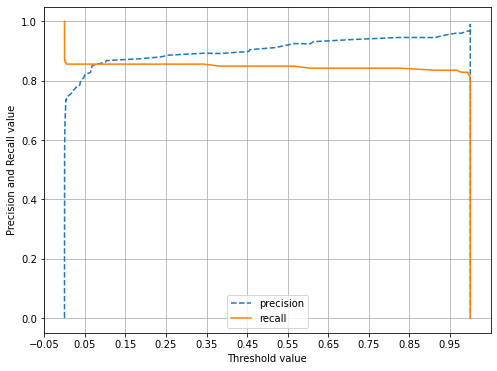

In [68]:
precision_recall_curve_plot(y_test, lgbm_clf.predict_proba(X_test)[:,1])